In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
def findFiles(path): return glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/My Drive/Colab Notebooks/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [0]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [0]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [0]:
import torch.nn as nn
import torch.nn.functional as F
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.ll0 = nn.Linear(input_size + hidden_size, hidden_size)
        self.ll1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.ll2 = nn.Linear(input_size + hidden_size, hidden_size)
        self.ll3 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, input, hidden, cell):
        combined = torch.cat((input, hidden), 1)
        ft = self.ll0(combined)
        ft = self.sig(ft)
        cell = cell * ft
        it = self.ll2(combined)
        it = self.sig(it)
        gt = self.ll1(combined)
        gt = self.sig(gt)
        pc = it*gt
        cell = cell + pc
        ot = self.ll3(combined)
        ct = self.tanh(cell)
        hidden = ct * ot
        output = self.i2o(hidden)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [72]:
input = lineToTensor('Albert')
hidden, cell = rnn.initHidden()

output, hidden, cell = rnn(input[0], hidden, cell)
print(output, output.size(), hidden.size(), cell.size())

tensor([[-0.0287, -0.0746,  0.0182,  0.0296,  0.0169, -0.0783, -0.0287,  0.0949,
          0.0739, -0.0500, -0.0454,  0.0826, -0.0707, -0.0397, -0.0245, -0.0449,
          0.0454, -0.0505]], grad_fn=<AddmmBackward>) torch.Size([1, 18]) torch.Size([1, 128]) torch.Size([1, 128])


In [73]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 7)


In [88]:
import random

def categChoice(l):
    return l[random.randint(0, len(l)-1)]
  
def trainChoice(l):
    return l[random.randint(0, int(len(l)*0.9) - 1)]

def testChoice(l):
    return l[random.randint(int(len(l)*0.9), len(l) - 1)]

def randomTrainingExample():
    category = categChoice(all_categories)
    line = trainChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTestExample():
    category = categChoice(all_categories)
    line = testChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Durand
category = Portuguese / line = Araullo
category = Arabic / line = Nader
category = Scottish / line = Mckay
category = Italian / line = Poggi
category = Chinese / line = Gok
category = Arabic / line = Daher
category = Irish / line = Faolan
category = Dutch / line = Kan
category = Spanish / line = Porra


In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden, cell = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = rnn(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [92]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 25s) 0.9219 Doan / Chinese ✗ (Vietnamese)
10000 10% (0m 51s) 0.5518 Tieu / Vietnamese ✓
15000 15% (1m 17s) 0.4170 De santigo / Portuguese ✓
20000 20% (1m 43s) 0.7241 Luc / Vietnamese ✓
25000 25% (2m 8s) 0.9325 Matos / Portuguese ✓
30000 30% (2m 34s) 2.5103 Sitta / Japanese ✗ (Czech)
35000 35% (3m 0s) 0.8350 Pelletier / French ✓
40000 40% (3m 25s) 2.6357 Schwarz / German ✗ (Czech)
45000 45% (3m 51s) 0.2715 Ying / Chinese ✓
50000 50% (4m 17s) 2.2878 Chmiel / English ✗ (Polish)
55000 55% (4m 43s) 2.4964 Nunes / Dutch ✗ (Portuguese)
60000 60% (5m 8s) 0.0119 Kuwabara / Japanese ✓
65000 65% (5m 34s) 0.2248 Araujo / Portuguese ✓
70000 70% (6m 0s) 0.2457 Thai / Vietnamese ✓
75000 75% (6m 25s) 0.3352 Sung / Korean ✓
80000 80% (6m 51s) 1.4039 Lauritz / French ✗ (German)
85000 85% (7m 17s) 1.9203 Porcher / German ✗ (French)
90000 90% (7m 43s) 0.0694 Rodriquez / Spanish ✓
95000 95% (8m 8s) 0.7402 Rutten / Dutch ✓
100000 100% (8m 34s) 0.8433 Stanzel / Czech ✓


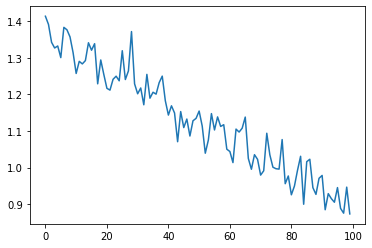

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

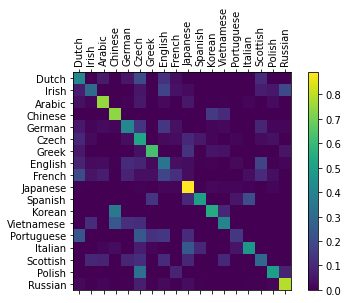

In [94]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden, cell = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = rnn(line_tensor[i], hidden, cell)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTestExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()